In [1]:
import pbjam as pb
from pbjam.jar import session
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk 
import sys

In [2]:
kic = '4448777'
numax = [220.0, 3.0]
dnu = [16.97, 0.01]
teff = [4750, 100]
bp_rp = [1.34, 0.01]

In [3]:
# Initialize a jam session with a single star:
jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], bp_rp = [bp_rp], 
                   nthreads=1, use_cached=False)

In [4]:
# Result is always a list of star class instances
# Taking the first one as an example
star = jam_sess.stars[0]

In [5]:
star.asymptotic_modeid(norders = 7)

Burningham
Sampling


In [6]:
print(star.asy_result.modeID)

    ell       nu_mu    nu_std
0     2  157.480234  0.325839
1     0  159.685892  0.292555
2     2  174.078155  0.362499
3     0  176.283610  0.329122
4     2  190.801472  0.393478
5     0  193.006600  0.360114
6     2  207.650860  0.417972
7     0  209.856728  0.384635
8     2  224.627226  0.435689
9     0  226.833011  0.402367
10    2  241.728922  0.446666
11    0  243.934755  0.413352
12    2  258.956771  0.451208
13    0  261.162851  0.417921


In [7]:
print(star.asy_result.summary)

           numax        dnu       eps     alpha       d02  env_height  \
16th  216.575967  16.921561  1.282096  0.006305  2.161681    2.969048   
2nd   216.347686  16.921561  1.282096  0.005964  2.150902    2.968961   
50th  216.933539  16.921595  1.282177  0.006391  2.166299    2.969794   
84th  217.714006  16.921654  1.282523  0.006477  2.169185    2.972877   
97th  217.714006  16.921758  1.282523  0.006505  2.169956    2.974242   
best  223.968636  17.015498  1.331103  0.007232  2.202837    4.310528   
mean  222.275744  17.002693  1.335898  0.007512  2.212454    4.247630   
skew   -0.627342  -2.867773 -2.083457  1.758031  3.459118   -4.682375   
std     1.631028   0.019455  0.013392  0.000554  0.036510    0.254866   

      env_width  mode_width         teff     bp_rp  
16th  57.009387   -1.166111  4668.276806  1.306736  
2nd   57.008648   -1.166131  4639.764194  1.301388  
50th  57.013021   -1.165390  4698.522525  1.310861  
84th  57.015316   -1.164715  4714.758006  1.313030  
97th

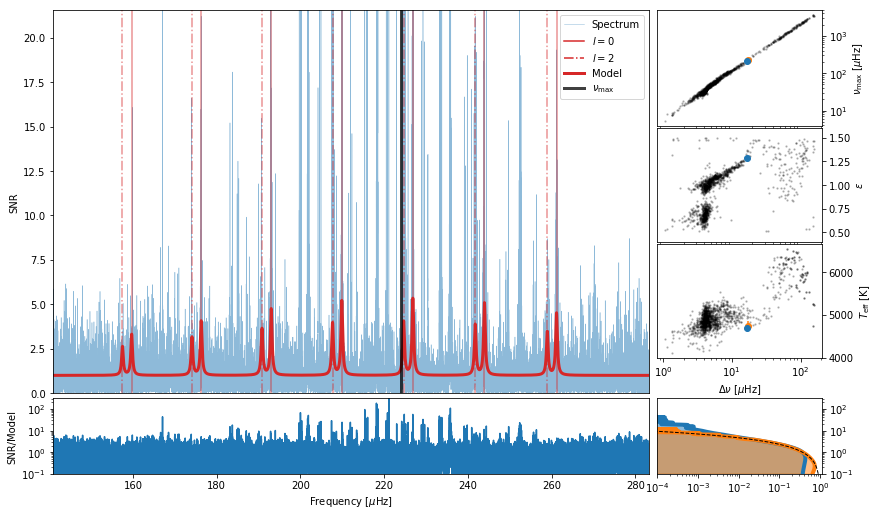

In [8]:
fig = star.plot_asyfit()

In [12]:
from pbjam import peakbag 
import pymc3 as pm
import importlib

In [103]:
importlib.reload(peakbag)
pb = peakbag.peakbag(star.f, star.s, star.asy_result)

{'l0': array([159.68589171, 176.28361041, 193.00660038, 209.8567278 ,
       226.83301095, 243.93475507, 261.16285121]), 'l2': array([157.48023375, 174.07815499, 190.80147171, 207.65086041,
       224.627226  , 241.72892209, 258.9567707 ]), 'width0': array([0.5003728 , 0.4899192 , 0.41341456, 0.54605906, 0.47343863,
       0.50301673, 0.48024105]), 'width2': array([0.48534186, 0.48534186, 0.48534186, 0.48534186, 0.48534186,
       0.48534186, 0.48534186]), 'height0': array([2.29817803, 3.04948273, 3.72531487, 4.18183331, 4.3051482 ,
       4.0567626 , 3.49209332]), 'height2': array([1.60872462, 2.13463791, 2.60772041, 2.92728332, 3.01360374,
       2.83973382, 2.44446533]), 'back': array([1., 1., 1., 1., 1., 1., 1.])}
[8, 9, 10, 11, 12, 13, 14]


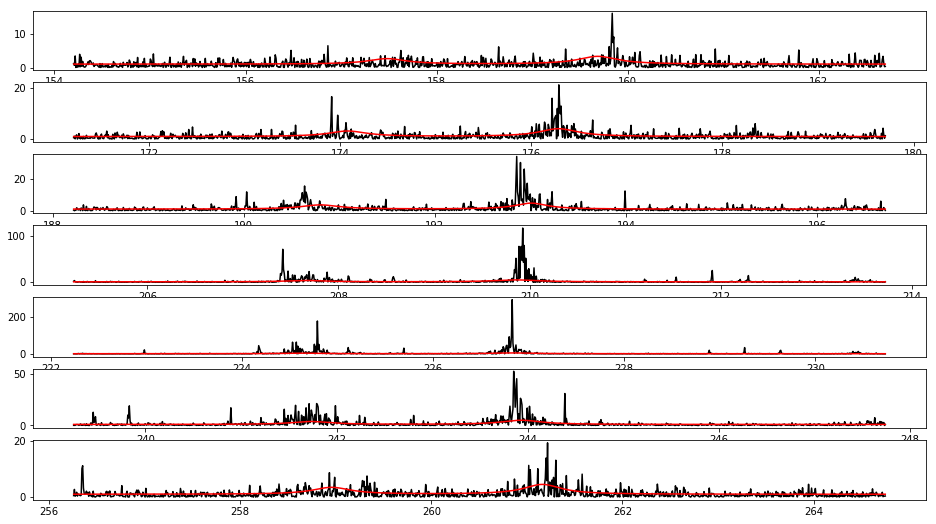

In [104]:
pb.plot_start_model()

In [ ]:
pb.sample(model_type='model_gp', cores=4, tune=1000)

[[0.        ]
 [0.16666667]
 [0.33333333]
 [0.5       ]
 [0.66666667]
 [0.83333333]
 [1.        ]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, ln_width2_rotated_, intercept2, gradient2, ln_width0_rotated_, intercept0, gradient0, l2, l0]
Sampling 4 chains:  39%|███▉      | 2336/6000 [05:20<10:54,  5.60draws/s]

In [ ]:
pm.summary(pb.samples)

In [ ]:
pb.plot_fit(thin=10)

In [ ]:
pb.plot_linewidth(thin=10)

In [ ]:
pb.plot_height(thin=10)